Import dan Setup

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import cv2

Load Dataset

In [9]:
graded_csv = r"E:\DragonEye\dataset\graded_features.csv"
quality_csv = r"E:\DragonEye\dataset\graded_texture_quality.csv"

df_grade = pd.read_csv(graded_csv)
df_quality = pd.read_csv(quality_csv)

df = pd.merge(df_grade, df_quality, on="filename", how="left")

print("Kolom setelah merge:", df.columns)
df.head()


FileNotFoundError: [Errno 2] No such file or directory: 'E:\\DragonEye\\dataset\\graded_texture_quality.csv'

Evaluasi Akurasi & Confusion Matrix

===== EVALUASI HASIL GRADING =====
Akurasi : 0.34772182254196643

Confusion Matrix:
 [[141   0   0]
 [139   0   4]
 [  4 125   4]]

Classification Report:
               precision    recall  f1-score   support

           A       0.50      1.00      0.66       141
           B       0.00      0.00      0.00       143
           C       0.50      0.03      0.06       133

    accuracy                           0.35       417
   macro avg       0.33      0.34      0.24       417
weighted avg       0.33      0.35      0.24       417



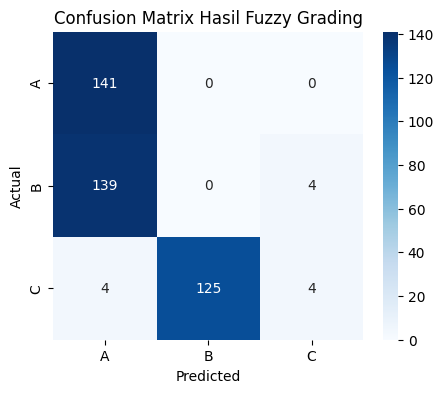

In [3]:
y_true = df['label_asli']
y_pred = df['grade_label']

print("===== EVALUASI HASIL GRADING =====")
print("Akurasi :", accuracy_score(y_true, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_true, y_pred))
print("\nClassification Report:\n", classification_report(y_true, y_pred))

cm = confusion_matrix(y_true, y_pred, labels=['A', 'B', 'C'])
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['A', 'B', 'C'], yticklabels=['A', 'B', 'C'])
plt.title("Confusion Matrix Hasil Fuzzy Grading")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Distribusi Grade

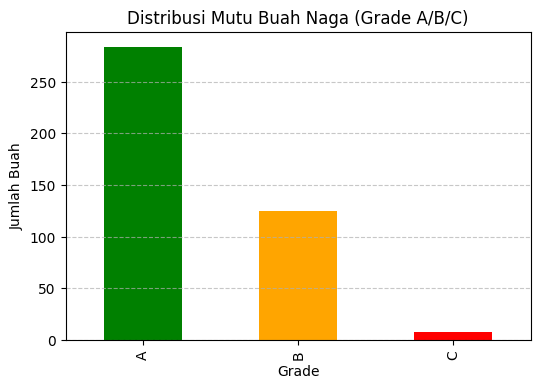

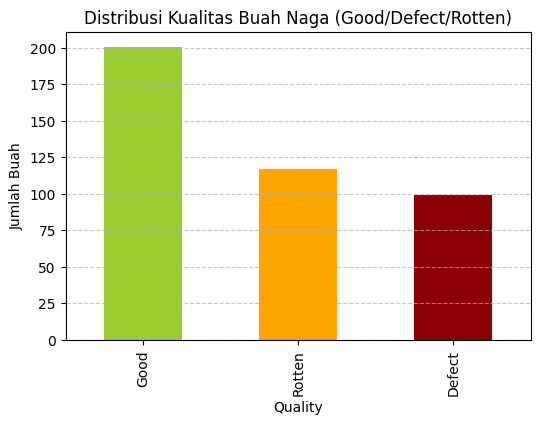

In [4]:
# Visualisasi distribusi grade berdasarkan grading (A/B/C)
plt.figure(figsize=(6, 4))
df['grade_label'].value_counts().plot(kind='bar', color=['green', 'orange', 'red'])
plt.title("Distribusi Mutu Buah Naga (Grade A/B/C)")
plt.xlabel("Grade")
plt.ylabel("Jumlah Buah")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Visualisasi distribusi kualitas berdasarkan kualitas (Good/Defect/Rotten)
plt.figure(figsize=(6, 4))
df['texture_grade_label'].value_counts().plot(kind='bar', color=['yellowgreen', 'orange', 'darkred'])
plt.title("Distribusi Kualitas Buah Naga (Good/Defect/Rotten)")
plt.xlabel("Quality")
plt.ylabel("Jumlah Buah")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


Visualisasi Sebaran Fitur

In [5]:
# Periksa kolom yang ada dalam DataFrame
print(df.columns)

# Scatter plot untuk ukuran dan berat berdasarkan grade
if 'area_cm2' in df.columns and 'weight_est_g' in df.columns:
    sns.scatterplot(data=df, x='area_cm2', y='weight_est_g', hue='grade_label', palette='Set1', s=60)
    plt.title("Sebaran Ukuran vs Berat Berdasarkan Grade")
    plt.xlabel("Area (Ukuran, cm²)")
    plt.ylabel("Estimasi Berat (gram)")
    plt.legend(title="Grade")
    plt.show()
else:
    print("Kolom 'area_cm2' atau 'weight_est_g' tidak ditemukan di DataFrame.")

# Scatter plot untuk ukuran dan berat berdasarkan kualitas (Good/Defect/Rotten)
if 'area_cm2' in df.columns and 'weight_est_g' in df.columns:
    sns.scatterplot(data=df, x='area_cm2', y='weight_est_g', hue='texture_grade_label', palette='Set2', s=60)
    plt.title("Sebaran Ukuran vs Berat Berdasarkan Kualitas")
    plt.xlabel("Area (Ukuran, cm²)")
    plt.ylabel("Estimasi Berat (gram)")
    plt.legend(title="Quality")
    plt.show()
else:
    print("Kolom 'area_cm2' atau 'weight_est_g' tidak ditemukan di DataFrame.")

Index(['filename', 'area_cm2_x', 'width_cm_x', 'height_cm_x', 'weight_est_g_x',
       'texture_score_x', 'hue_mean_x', 'grade_by_weight', 'area_norm',
       'weight_norm', 'texture_norm_x', 'fuzzy_score', 'grade_label',
       'label_asli', 'area_cm2_y', 'width_cm_y', 'height_cm_y',
       'weight_est_g_y', 'texture_score_y', 'hue_mean_y', 'hue_norm',
       'texture_norm_y', 'texture_grade_score', 'texture_grade_label'],
      dtype='object')
Kolom 'area_cm2' atau 'weight_est_g' tidak ditemukan di DataFrame.
Kolom 'area_cm2' atau 'weight_est_g' tidak ditemukan di DataFrame.


Uji Hasil

In [ ]:
import tkinter as tk
from tkinter import filedialog
import cv2
import numpy as np
import pandas as pd
from feature_extraction import extract_features
from preprocessing import preprocess_image
from segmentation import segment_image
from fuzzy_grading import grade_by_weight, normalize_pct
from fuzzy_grading import fuzzy_scores

def load_image_from_file():
    """Allow the user to select an image file and load it."""
    root = tk.Tk()
    root.withdraw()  # Hide the Tkinter root window
    file_path = filedialog.askopenfilename(title="Select Image File", filetypes=[("Image Files", "*.jpg;*.jpeg;*.png")])
    if file_path:
        return cv2.imread(file_path)
    return None

def evaluate_image(image):
    """Evaluate the grading of the selected image."""
    if image is None:
        return "No image loaded"

    # Preprocessing (convert to HSV, etc.)
    hsv = preprocess_image(image)

    # Segment the image to isolate the dragon fruit
    segmented, mask = segment_image(hsv)

    # Extract features (area, width, height, weight, texture, hue)
    area, width, height, weight, texture_score, hue_mean = extract_features(segmented, mask)

    # Grading based on weight
    grade = grade_by_weight(weight)

    # Normalize features for fuzzy logic grading
    area_norm = normalize_pct(pd.Series([area]), low_pct=5, high_pct=95)[0]
    weight_norm = normalize_pct(pd.Series([weight]), low_pct=5, high_pct=95)[0]
    texture_norm = normalize_pct(pd.Series([texture_score]), low_pct=5, high_pct=95)[0]

    # Fuzzy grading (if applicable)
    fuzzy_grade = fuzzy_scores[0]  # Get the first fuzzy score for the example

    # Display the results
    return {
        "area": area,
        "width": width,
        "height": height,
        "weight": weight,
        "texture_score": texture_score,
        "hue_mean": hue_mean,
        "grade_by_weight": grade,
        "fuzzy_grade_score": fuzzy_grade
    }

# Example of testing
image = load_image_from_file()
result = evaluate_image(image)
print(result)


ImportError: cannot import name 'fuzzy_grading_quality' from 'fuzzy_grading' (e:\DragonEye\src\fuzzy_grading.py)